# FinBERT
FinBERT is a language model based on BERT and mainly tackling NLP tasks in the financial domain.

In [22]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")

import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
import numpy as np

from transformers import BertTokenizer, BertForSequenceClassification, pipeline

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /Users/irene/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [118]:
esg_corpus=pd.read_pickle("/Users/irene/PycharmProjects/webscraping/ESG/ESG/temp/esg_corpus_comprehensive.p")

In [119]:
esg_corpus.head()

,release_time,identifier,fiscal_year,stock_code,en_name,cn_name,ind_code1,ind_name1,ind_code2,ind_name2,ind_code3,ind_name3,esg_report
0,06/07/2016 16:32,2016_01816,2015,01816,CGN POWER,中廣核電力,40,公用事業,4000,公用事業,400010,電力,"Stock Code: CGN Power Co., Ltd.*(A joint stock..."
1,05/07/2016 22:43,2016_01558,2015,01558,HEC PHARM,東陽光藥,28,醫療保健,2810,藥品及生物科技,281010,藥品,"YiChang HEC ChangJiang Pharmaceutical Co., Ltd..."
2,30/06/2016 18:51,2016_00242,2015,00242,SHUN TAK HOLD,信德集團,80,綜合企業,8000,綜合企業,800010,綜合企業,The design concept is inspired by the traditio...
3,30/06/2016 16:55,2016_00003,2015,00003,HK & CHINA GAS,香港中華煤氣,40,公用事業,4000,公用事業,400020,燃氣,SUSTAINABILITYREPORT(Stock code: ) INNOVATION ...
4,23/06/2016 12:20,2016_01185,2015,01185,CHINA ENERGINE,中國航天萬源,10,工業,1010,工業工程,101030,環保工程,CONTENTSAbout this Report Group Profile St...


In [120]:
esg_corpus_copy = esg_corpus.copy()

In [26]:
# nltk sentence tokenizer
tokenizer = RegexpTokenizer(r'\w+')

token_sentences = []
for doc in esg_corpus_copy["esg_report"].to_list():
    clean_sent=[]
    for sent in sent_tokenize(doc):
        # collect the sentence with more than 4 words
        if len(tokenizer.tokenize(sent)) > 4: 
            clean = " ".join(tokenizer.tokenize(sent))
            clean = clean.lower()
            clean_sent.append(clean)
        else:
            pass 
    token_sentences.append(clean_sent)
    
esg_corpus_copy["tokenized_sent"]=token_sentences

In [97]:
# FinBERT 
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

In [121]:
# an example
token_sentences[0][100]

'in june the upgrade of water recycling pipelines was completed'

In [122]:
nlp(token_sentences[0][100])

[{'label': 'Environmental', 'score': 0.9603898525238037}]

we dismiss the information about the probability but only keep the label and calculate the proportion of the 3 dimension (include None is 4 cats, the None cat might be a proxy for the irrelevant information/noise)

In [105]:
esg_corpus_copy.to_pickle("/Users/irene/PycharmProjects/webscraping/ESG/ESG/temp/esg_sent.p")

In [ ]:
'''create a dataframe containing:
fiscal_year, stock_code, ind_name1, ind_name2, E_proportion, S_proportion, G_proportion, None_proportion
WARNING: This will take a very long time (almost 3-4 days) to run!
To replicate, just use the esg_proportion.csv which is generate from this code.
'''

for idx in range(len(esg_corpus_copy)):
    try:
        print("processing", ":", f'{idx}/{len(esg_corpus_copy)}')

        info_dict={}

        # basic info
        info_dict["fiscal_year"] = esg_corpus_copy['fiscal_year'][idx]
        info_dict["stock_code"] = esg_corpus_copy['stock_code'][idx]
        info_dict["ind_name1"] = esg_corpus_copy['ind_name1'][idx]
        info_dict["ind_name2"] = esg_corpus_copy['ind_name2'][idx]

        # ESG
        esg=[]
        if len(esg_corpus_copy['tokenized_sent'][idx]) < 500:
            for sent in esg_corpus_copy['tokenized_sent'][idx]:
                # ignore tooooo long obs (which may derived from the wrongly sent tokenize [one limitation]))
                try:
                    esg.append(nlp(sent)[0])
                except RuntimeError:
                    pass

            esg_df=pd.DataFrame(esg)
            esg_proportion=esg_df.groupby('label').count()/len(esg_df)
            try: 
                info_dict["E_proportion"] = esg_proportion["score"][0]
                info_dict["G_proportion"] = esg_proportion["score"][1]
                info_dict["None_proportion"] = esg_proportion["score"][2]
                info_dict["S_proportion"] = esg_proportion["score"][3]

                # write each paper's information into the path
                header = ['fiscal_year', 'stock_code', 'ind_name1', 'ind_name2', 
                        "E_proportion",'G_proportion','None_proportion','S_proportion']
                
                store_path = "/Users/irene/PycharmProjects/webscraping/ESG/ESG/temp/esg_proportion.csv"

                with open(store_path, 'a+', newline='', encoding='utf-8') as f:
                    f_csv = csv.DictWriter(f, fieldnames=header)

                    # check if the csv file has a header already
                    if os.path.getsize(store_path) == 0:
                        f_csv.writeheader()
                    else:
                        pass

                    # write the obs one by one to avoid lost of information
                    f_csv.writerow(info_dict)
            except: 
                pass
        else:
            print("too large")
    except:
        print("too small")
    


sentence greater than 500 are approx 500 ge. we drop them to speed up the process

After we loop all the docs, we get the esg_proportion.csv

In [127]:
esg_proportion = pd.read_csv("/Users/irene/PycharmProjects/webscraping/ESG/ESG/esg_proportion/esg_proportion.csv")

In [131]:
esg_proportion.head()

,Unnamed: 0,fiscal_year,stock_code,ind_name1,ind_name2,E_proportion,G_proportion,None_proportion,S_proportion
0,0,2015,1816,公用事業,公用事業,0.423729,0.067797,0.107345,0.401130
1,1,2015,1558,醫療保健,藥品及生物科技,0.225914,0.076412,0.179402,0.518272
2,2,2015,242,綜合企業,綜合企業,0.275862,0.087533,0.066313,0.570292
3,3,2015,3,公用事業,公用事業,0.346908,0.076923,0.058824,0.517345
4,4,2015,1185,工業,工業工程,0.205479,0.068493,0.136986,0.589041


# By Industry

In [132]:
byind1 = esg_proportion.groupby("ind_name1")[["E_proportion", "G_proportion", "None_proportion","S_proportion"]].mean()

In [133]:
title=['Utilities',
 'Materials',
 'Properties & Construction',
 'Industrials',
 'Consumer Staples',
 'Conglomerates',
 'Energy',
 'Information Technology',
 'Healthcare',
 'Financials',
 'Telecommunications',
 'Consumer Discretionary']

byind1=byind1.reset_index()
title_cn = byind1["ind_name1"].to_list()
dict = {title_cn[i]: title[i] for i in range(len(title_cn))}
byind1["ind_en"] = title
del byind1["ind_name1"]

In [134]:
byind1=pd.melt(byind1, id_vars="ind_en")

In [135]:
byind1

,ind_en,variable,value
0,Utilities,E_proportion,0.416222
1,Materials,E_proportion,0.405163
2,Properties & Construction,E_proportion,0.353648
3,Industrials,E_proportion,0.368460
4,Consumer Staples,E_proportion,0.355137
5,Conglomerates,E_proportion,0.341610
6,Energy,E_proportion,0.361061
7,Information Technology,E_proportion,0.322991
8,Healthcare,E_proportion,0.312502
9,Financials,E_proportion,0.264372


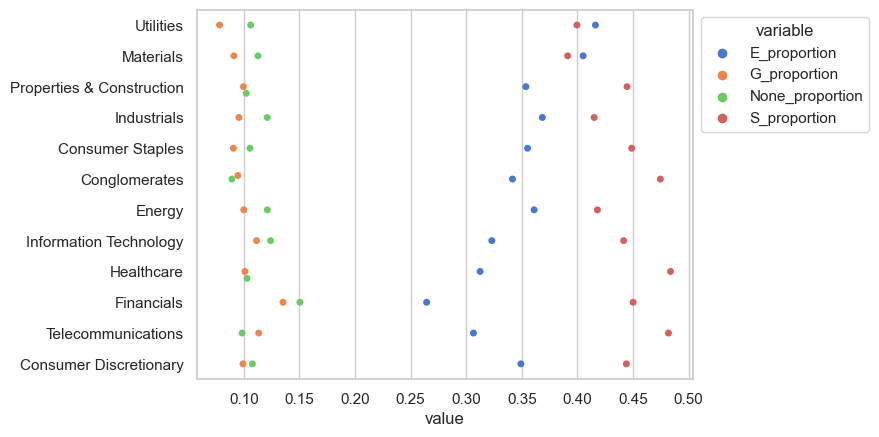

In [136]:
ax = sns.swarmplot(data=byind1, x="value", y="ind_en", hue="variable")
ax.set(ylabel="")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# By years

In [137]:
byyear = esg_proportion.groupby("fiscal_year")[["E_proportion", "G_proportion", "None_proportion","S_proportion"]].mean()

In [138]:
byyear

,E_proportion,G_proportion,None_proportion,S_proportion
fiscal_year,,,,
2012,0.186608,0.142849,0.261632,0.408910
2013,0.273429,0.060120,0.176792,0.489658
2014,0.270014,0.074756,0.185186,0.470045
2015,0.279575,0.077780,0.151358,0.491286
2016,0.309631,0.097796,0.112008,0.480565
2017,0.344298,0.093805,0.112607,0.449290
2018,0.359793,0.094074,0.112067,0.434067
2019,0.361284,0.097928,0.108077,0.432711
2020,0.350962,0.100763,0.112089,0.436185


In [139]:
byyear=byyear.reset_index()

In [140]:
byyear

,fiscal_year,E_proportion,G_proportion,None_proportion,S_proportion
0,2012,0.186608,0.142849,0.261632,0.408910
1,2013,0.273429,0.060120,0.176792,0.489658
2,2014,0.270014,0.074756,0.185186,0.470045
3,2015,0.279575,0.077780,0.151358,0.491286
4,2016,0.309631,0.097796,0.112008,0.480565
5,2017,0.344298,0.093805,0.112607,0.449290
6,2018,0.359793,0.094074,0.112067,0.434067
7,2019,0.361284,0.097928,0.108077,0.432711
8,2020,0.350962,0.100763,0.112089,0.436185
9,2021,0.356829,0.111942,0.113939,0.417291


In [141]:
byyear=pd.melt(byyear, id_vars="fiscal_year")

In [142]:
byyear

,fiscal_year,variable,value
0,2012,E_proportion,0.186608
1,2013,E_proportion,0.273429
2,2014,E_proportion,0.270014
3,2015,E_proportion,0.279575
4,2016,E_proportion,0.309631
5,2017,E_proportion,0.344298
6,2018,E_proportion,0.359793
7,2019,E_proportion,0.361284
8,2020,E_proportion,0.350962
9,2021,E_proportion,0.356829


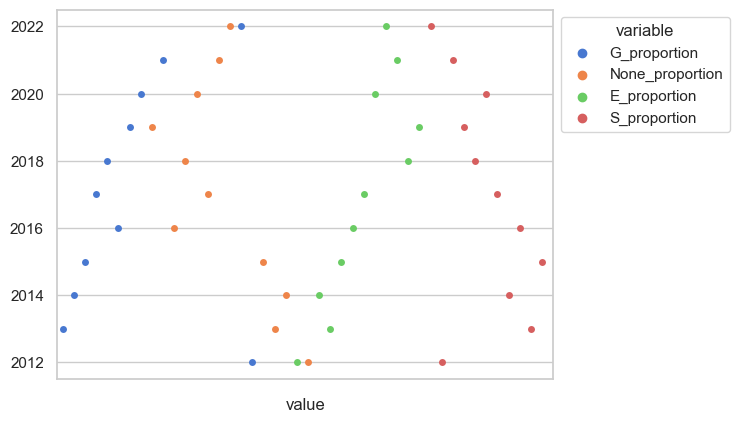

In [146]:
ax = sns.swarmplot(data=byyear, x="value", y="fiscal_year", hue="variable")
ax.set(ylabel="", xticks="")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))